# Template Based Chord Recognition

## Chromagram

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [ ]:
### https://freesound.org/people/TheSamplesFactory/sounds/431733/
!gdown 1tyjDjS7OI8jcdSzu0QpZJ7v7rB0cxx3d

Downloading...
From: https://drive.google.com/uc?id=1tyjDjS7OI8jcdSzu0QpZJ7v7rB0cxx3d
To: /content/chord.wav
100% 2.51M/2.51M [00:00<00:00, 71.0MB/s]


In [ ]:
audio, sr = librosa.load('chord.wav')

In [ ]:
from IPython.display import Audio

Audio(data=audio, rate=sr)

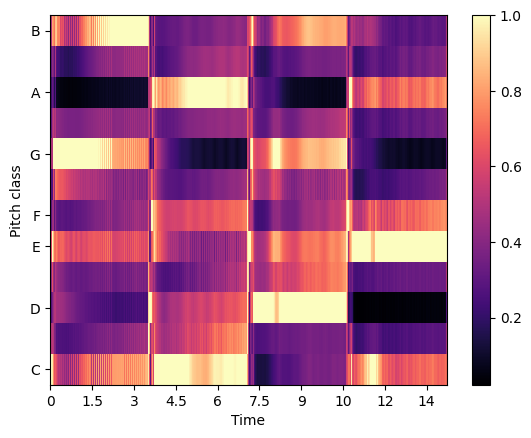

In [ ]:
### compute chromagram
S = np.abs(librosa.stft(y=audio))
chromagram = librosa.feature.chroma_stft(S=S, sr=sr)

fig = plt.figure()
img = librosa.display.specshow(chromagram, y_axis='chroma', x_axis='time')
fig.colorbar(img)

## Chord Templates

In [ ]:
### generate chord labels
chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
chord_labels_maj = chroma_labels
chord_labels_min = [s + 'm' for s in chroma_labels]
chord_labels = chord_labels_maj + chord_labels_min

In [ ]:
chord_labels

['C',
 'C#',
 'D',
 'D#',
 'E',
 'F',
 'F#',
 'G',
 'G#',
 'A',
 'A#',
 'B',
 'Cm',
 'C#m',
 'Dm',
 'D#m',
 'Em',
 'Fm',
 'F#m',
 'Gm',
 'G#m',
 'Am',
 'A#m',
 'Bm']

In [ ]:
### generate chord templates
template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
num_chord = len(chord_labels)
chord_templates = np.ones((12, num_chord))
for shift in range(num_chord//2):
    chord_templates[:, shift] = np.roll(template_cmaj, shift)
    chord_templates[:, shift+12] = np.roll(template_cmin, shift)

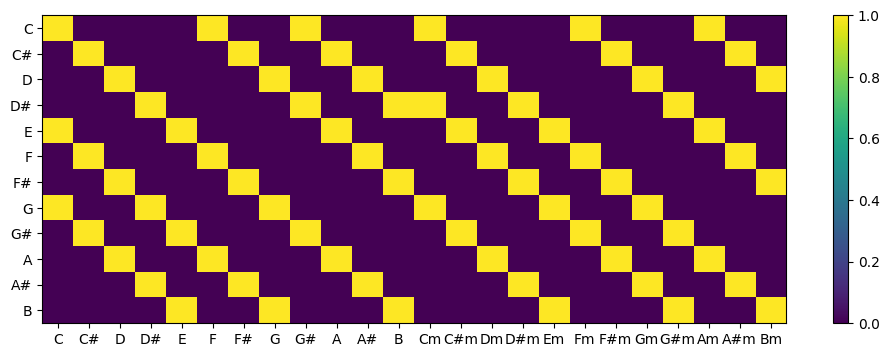

In [ ]:
plt.figure(figsize=(12,4))
plt.imshow(chord_templates, aspect='auto')
plt.colorbar()
plt.xticks(np.arange(num_chord), chord_labels)
plt.yticks(np.arange(num_chord//2), chroma_labels)
plt.show()

## Chord Recognition

In [ ]:
### compute chord similarity
def compute_similarity(a, b):
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

chord_sim = np.zeros((num_chord, chromagram.shape[1]))
for frame in range(chord_sim.shape[1]):
  for chord in range(num_chord):
    chord_sim[chord][frame] = compute_similarity(chromagram[:, frame], chord_templates[:, chord])

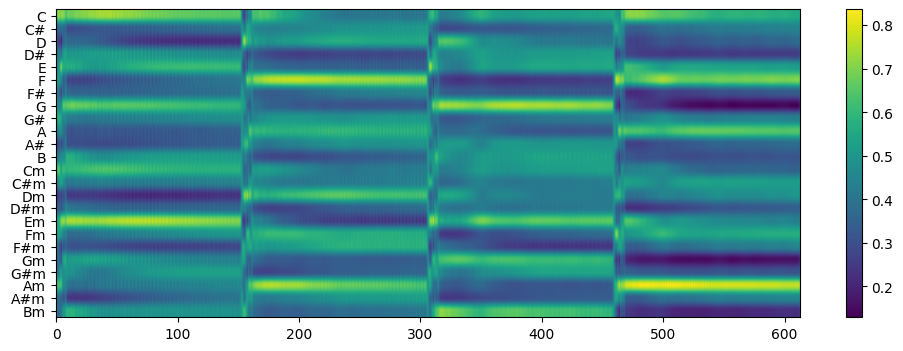

In [ ]:
plt.figure(figsize=(12,4))
plt.imshow(chord_sim, aspect='auto')
plt.colorbar()
plt.yticks(np.arange(num_chord), chord_labels)
plt.show()

In [ ]:
### find maximizing chords
chord_max_index = np.argmax(chord_sim, axis=0)
chord_max = np.zeros(chord_sim.shape).astype(np.int32)
for n in range(chord_sim.shape[1]):
    chord_max[chord_max_index[n], n] = 1

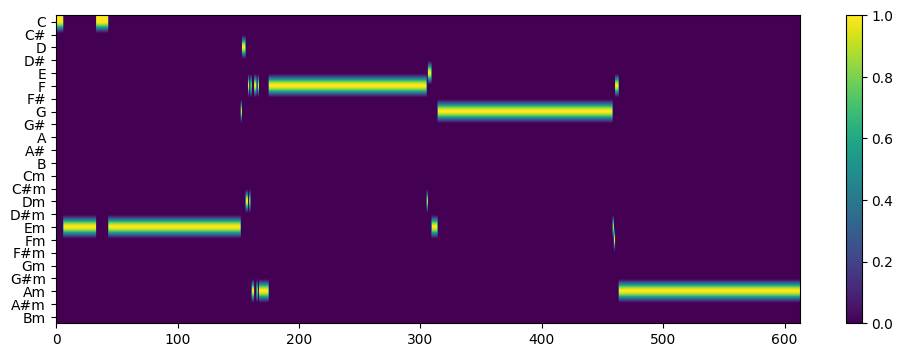

In [ ]:
plt.figure(figsize=(12,4))
plt.imshow(chord_max, aspect='auto')
plt.colorbar()
plt.yticks(np.arange(num_chord), chord_labels)
plt.show()

# Hidden Markov Model Based Chord Recognition

## Hidden Markov Model

In [ ]:
### compute emission likelihoods
B = np.copy(chord_sim)
norm = np.sum(B, axis=0)
B = B / norm

In [ ]:
### define state transition probability
A = librosa.sequence.transition_loop(24, 0.5)

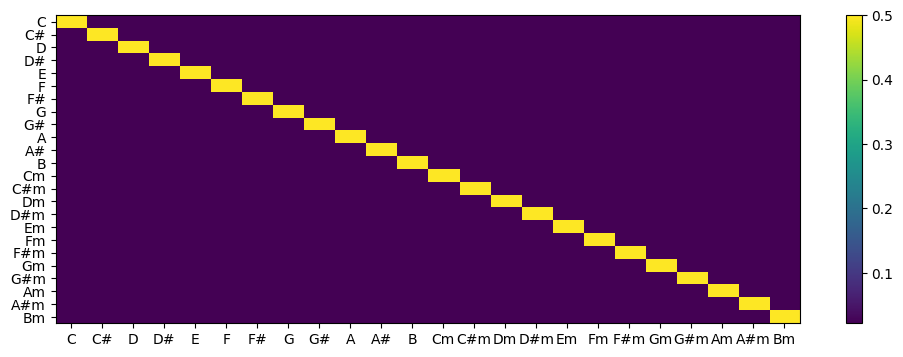

In [ ]:
plt.figure(figsize=(12,4))
plt.imshow(A, aspect='auto')
plt.colorbar()
plt.xticks(np.arange(num_chord), chord_labels)
plt.yticks(np.arange(num_chord), chord_labels)
plt.show()

## Viterbi Algorithm

In [ ]:
### decode state sequence from observation
state, _ = librosa.sequence.viterbi(prob=B, transition=A, return_logp=True)

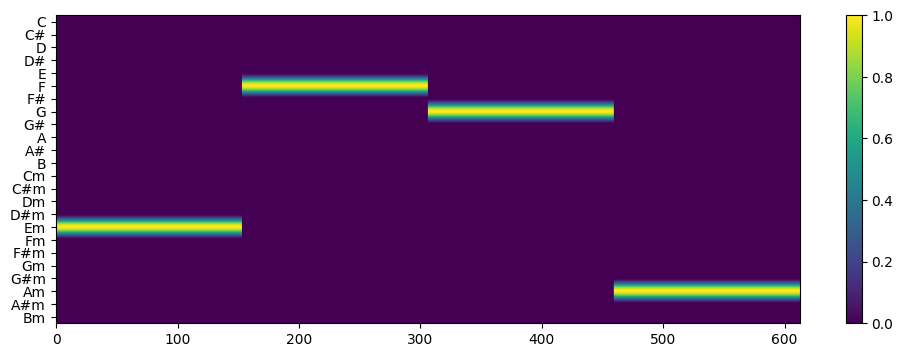

In [ ]:
chord = np.zeros(B.shape).astype(np.int32)
for n in range(B.shape[1]):
    chord[state[n], n] = 1

plt.figure(figsize=(12,4))
plt.imshow(chord, aspect='auto')
plt.colorbar()
plt.yticks(np.arange(num_chord), chord_labels)
plt.show()